In [1]:
%cd /Users/masha/Documents/visual-reasoning

/Users/masha/Documents/visual-reasoning


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import timm
import kornia.geometry.transform as K
import cv2
import random

/Users/masha/Documents/visual-reasoning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
BATCH_SIZE = 64
IMG_SIZE = 64   # Match your 3D dataset resolution
EPOCHS = 500     # Will fly by now

CHIRAL_SHAPES = {
    'L': [(0, -1), (0, 0), (0, 1), (1, 1)],
    'J': [(0, -1), (0, 0), (0, 1), (-1, 1)],
    'S': [(0, 0), (1, 0), (0, 1), (-1, 1)],
    'Z': [(0, 0), (-1, 0), (0, 1), (1, 1)],
    'F': [(0, 0), (0, -1), (1, -1), (-1, 0), (0, 1)],
    'P': [(0, 0), (0, -1), (1, -1), (1, 0), (0, 1)],
}

def draw_shape(name, size):
    img = np.zeros((size, size), dtype=np.uint8)
    center = size // 2
    block_size = size // 8 # Scaling block size relative to image
    for dx, dy in CHIRAL_SHAPES[name]:
        x = center + (dx * block_size) - (block_size // 2)
        y = center + (dy * block_size) - (block_size // 2)
        cv2.rectangle(img, (x, y), (x + block_size, y + block_size), 255, -1)
    return img

dino = timm.create_model("vit_small_patch16_dinov3", pretrained=True).to(DEVICE).eval()

SHAPE_CACHE = {} # Stores { 'L': {'img': 64x64_tensor, 'emb': 384_vector} }

with torch.no_grad():
    for name in CHIRAL_SHAPES.keys():
        big_img = draw_shape(name, 224)
        t_big = torch.tensor(big_img).float().unsqueeze(0).unsqueeze(0).repeat(1,3,1,1).to(DEVICE) / 255.0
        t_big = transforms.Normalize([0.485], [0.229])(t_big)
        
        emb = dino.forward_features(t_big)[:, 0, :] # [1, 384]
        
        small_img = draw_shape(name, 64)
        t_small = torch.tensor(small_img).float().unsqueeze(0) / 255.0 # [1, 64, 64]
        t_small = (t_small - 0.5) / 0.5
        
        SHAPE_CACHE[name] = {'img': t_small, 'emb': emb.cpu()} # Store emb on CPU to save GPU RAM

del dino # Free up memory

class FastTetrisDataset(Dataset):
    def __init__(self, n_samples=2000):
        self.keys = list(CHIRAL_SHAPES.keys())
        self.n = n_samples
    def __len__(self): return self.n
    def __getitem__(self, idx):
        # Just return the base shape and its pre-computed embedding
        key = random.choice(self.keys)
        data = SHAPE_CACHE[key]
        return data['img'], data['emb'] # (1, 64, 64), (1, 384)

train_loader = DataLoader(FastTetrisDataset(100000), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(FastTetrisDataset(10000), batch_size=BATCH_SIZE)

In [7]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class FastRotator(nn.Module):
    def __init__(self, backbone_dim=384, flow_dim=32): # Reduced flow_dim to 32
        super().__init__()
        
        # Embeddings
        self.time_mlp = nn.Sequential(nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4))
        self.angle_mlp = nn.Sequential(nn.Linear(1, flow_dim*4), nn.GELU(), nn.Linear(flow_dim*4, flow_dim*4))
        self.cond_proj = nn.Linear(backbone_dim, flow_dim*4)

        self.inc = DoubleConv(1, flow_dim) 
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(flow_dim, flow_dim*2))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(flow_dim*2, flow_dim*4))
        
        self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv1 = DoubleConv(flow_dim*6, flow_dim*2)
        self.up2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv2 = DoubleConv(flow_dim*3, flow_dim)
        
        self.outc = nn.Conv2d(flow_dim, 1, kernel_size=1) # Output 1 channel

    def forward(self, x_t, t, dino_emb, target_angle_deg):
        # Condition
        t_emb = self.time_mlp(t)
        d_emb = self.cond_proj(dino_emb)
        a_emb = self.angle_mlp(target_angle_deg / 360.0)
        
        global_cond = (t_emb + d_emb + a_emb).unsqueeze(-1).unsqueeze(-1)

        # Flow
        x1 = self.inc(x_t)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        
        x3 = x3 + global_cond 
        
        x = self.conv1(torch.cat([self.up1(x3), x2], dim=1))
        x = self.conv2(torch.cat([self.up2(x), x1], dim=1))
        return self.outc(x)

model = FastRotator().to(DEVICE)
optimizer = optim.AdamW(model.parameters(), lr=2e-4)

Epoch 5: 1.13912
Epoch 10: 0.69113
Epoch 15: 0.49457
Epoch 20: 0.38378
Epoch 25: 0.29749
Epoch 30: 0.22562
Epoch 35: 0.19983
Epoch 40: 0.18478
Epoch 45: 0.15858
Epoch 50: 0.14458
Epoch 55: 0.14428
Epoch 60: 0.12789
Epoch 65: 0.11867
Epoch 70: 0.12273
Epoch 75: 0.11153
Epoch 80: 0.09720
Epoch 85: 0.09209
Epoch 90: 0.08580
Epoch 95: 0.08761
Epoch 100: 0.09034


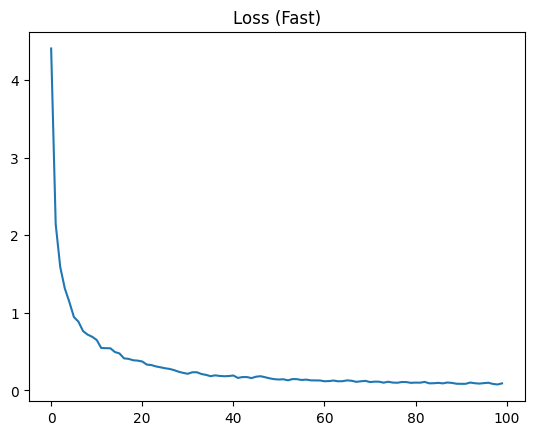

In [58]:
train_losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for base_img, base_emb in train_loader:
        base_img = base_img.to(DEVICE) # (B, 1, 64, 64)
        base_emb = base_emb.to(DEVICE).squeeze(1) # (B, 384)
        B = base_img.shape[0]
        
        ang_start = torch.rand(B, device=DEVICE) * 360
        ang_delta = torch.rand(B, device=DEVICE) * 360 - 180 
        
        # Geodesic Construction
        t = torch.rand(B, 1, device=DEVICE)
        
        # Rotate Base Image to Current Time t
        ang_t = ang_start + (t.squeeze() * ang_delta)
        x_t = K.rotate(base_img, ang_t)
        
        # Rotate Base Image to Next Time (Target)
        dt = 0.1
        ang_next = ang_t + (dt * ang_delta)
        x_next = K.rotate(base_img, ang_next)
        
        target_v = (x_next - x_t) / dt
        
        # Note: We pass base_emb. Logic: "It's an L (emb), rotate it (angle)."
        pred_v = model(x_t, t, base_emb, ang_delta.view(B, 1))
        
        loss = F.mse_loss(pred_v, target_v)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    avg = epoch_loss / len(train_loader)
    train_losses.append(avg)
    if (epoch+1) % 5 == 0: print(f"Epoch {epoch+1}: {avg:.5f}")

plt.plot(train_losses); plt.title("Loss (Fast)"); plt.show()

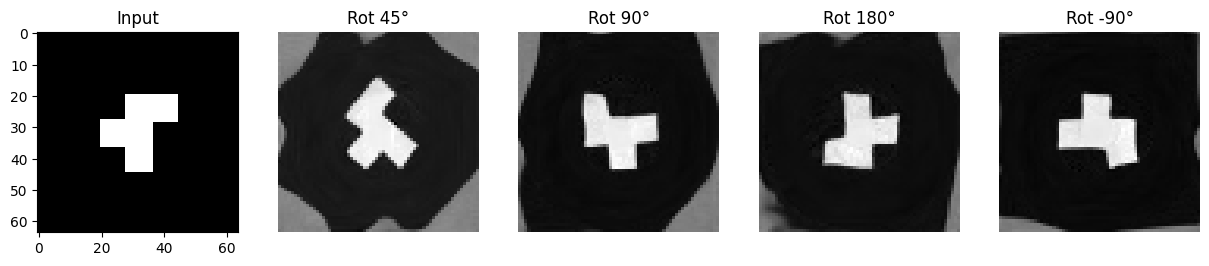

In [64]:
@torch.no_grad()
def apply_rotation(model, base_img, base_emb, angle_deg, steps=10):
    model.eval()
    dt = 1.0 / steps
    curr = base_img.clone()
    B = base_img.shape[0]
    
    target_ang = torch.full((B, 1), angle_deg, device=DEVICE)
    
    for i in range(steps):
        t = torch.full((B, 1), i/steps, device=DEVICE)
        v = model(curr, t, base_emb, target_ang)
        curr = curr + v * dt
        
    return curr

# Visualize
data = next(iter(test_loader))
sample_img = data[0][0:1].to(DEVICE)
sample_emb = data[1][0:1].to(DEVICE).squeeze(1)

angles = [45, 90, 180, -90]
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

axes[0].imshow(sample_img[0,0].cpu(), cmap='gray')
axes[0].set_title("Input")

for i, ang in enumerate(angles):
    out = apply_rotation(model, sample_img, sample_emb, float(ang))
    axes[i+1].imshow(out[0,0].cpu(), cmap='gray')
    axes[i+1].set_title(f"Rot {ang}°")
    axes[i+1].axis('off')

plt.show()

In [65]:
torch.save(model.state_dict(), "models/rotator_l2_100e_10k.pth")

In [ ]:
# Re-init model with slightly more capacity
model = FastRotator(flow_dim=64).to(DEVICE) # Up from 32
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

# Scheduler: Starts low, goes high, then decays to almost zero
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=1e-3, 
    steps_per_epoch=len(train_loader), 
    epochs=EPOCHS
)

train_losses = []
print(f"Refined Training on {DEVICE} (L1 Loss + Scheduler)...")

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    
    for base_img, base_emb in train_loader:
        base_img = base_img.to(DEVICE)
        base_emb = base_emb.to(DEVICE).squeeze(1)
        B = base_img.shape[0]
        
        ang_start = torch.rand(B, device=DEVICE) * 360
        ang_delta = torch.rand(B, device=DEVICE) * 360 - 180 
        t = torch.rand(B, 1, device=DEVICE)
        
        # Current State
        ang_t = ang_start + (t.squeeze() * ang_delta)
        x_t = K.rotate(base_img, ang_t)
        
        dt = 0.1
        x_next = K.rotate(base_img, ang_t + (dt * ang_delta))
        target_v = (x_next - x_t) / dt
        
        pred_v = model(x_t, t, base_emb, ang_delta.view(B, 1))
        
        # L1 Loss for sharper edges
        loss = F.l1_loss(pred_v, target_v)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step() # Update LR
        
        epoch_loss += loss.item()
        
    avg = epoch_loss / len(train_loader)
    train_losses.append(avg)
    
    if (epoch+1) % 10 == 0: 
        print(f"Epoch {epoch+1}: Loss {avg:.5f}")

plt.plot(train_losses)
plt.title("Geodesic Rotator L1 Training Loss")
plt.show()

Refined Training on mps (L1 Loss + Scheduler)...


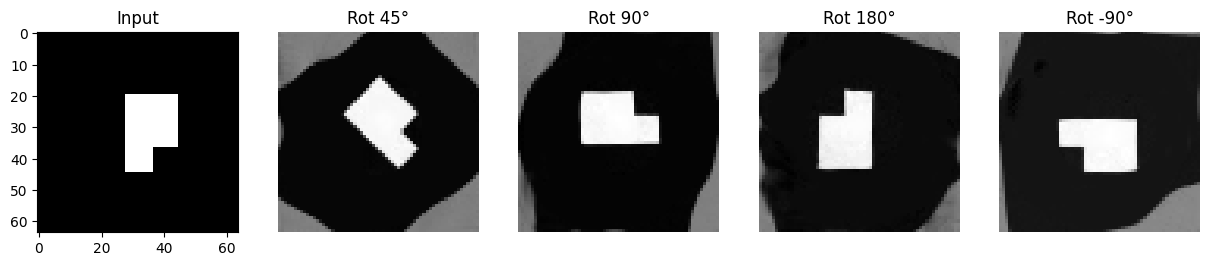

In [ ]:
data = next(iter(test_loader))
sample_img = data[0][0:1].to(DEVICE)
sample_emb = data[1][0:1].to(DEVICE).squeeze(1)

angles = [45, 90, 180, -90]
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

axes[0].imshow(sample_img[0,0].cpu(), cmap='gray')
axes[0].set_title("Input")

for i, ang in enumerate(angles):
    out = apply_rotation(model, sample_img, sample_emb, float(ang))
    axes[i+1].imshow(out[0,0].cpu(), cmap='gray')
    axes[i+1].set_title(f"Rot {ang}°")
    axes[i+1].axis('off')

plt.show()

In [ ]:
torch.save(model.state_dict(), "models/rotator_l1_500e_100k.pth")